# 1.2 Marginal Gaussianization

In [6]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

<Figure size 432x288 with 0 Axes>

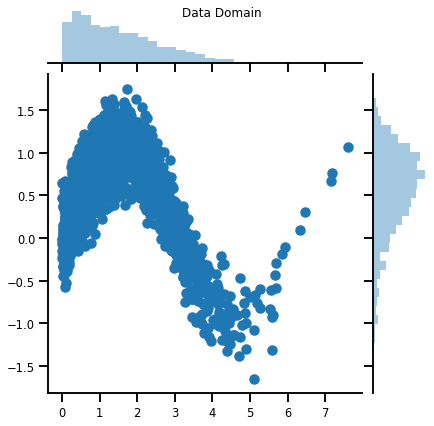

In [7]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

In [8]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [10]:
from typing import Union
from rbig_jax.utils import get_domain_extension





def univariate_histogram(
    n_samples: int, 
    nbins: int, 
    support_extension: Union[int, float]=10,
    precision: int = 1_000,
    alpha: float = 1e-5
):
    
    
    # TODO a bin initialization function
    
    def init_fun(inputs):

        # get histogram counts and bin edges
        counts, bin_edges = np.histogram(inputs, bins=nbins)

        # add regularization
        counts = np.array(counts) + alpha

        # get bin centers and sizes
        bin_centers = np.mean(np.vstack((bin_edges[0:-1], bin_edges[1:])), axis=0)
        bin_size = bin_edges[2] - bin_edges[1]

        # =================================
        # PDF Estimation
        # =================================
        # pdf support
        pdf_support = np.hstack(
            (bin_centers[0] - bin_size, bin_centers, bin_centers[-1] + bin_size)
        )
        # empirical PDF
        empirical_pdf = np.hstack((0.0, counts / (np.sum(counts) * bin_size), 0.0))

        # =================================
        # CDF Estimation
        # =================================
        c_sum = np.cumsum(counts)
        cdf = (1 - 1 / n_samples) * c_sum / n_samples

        incr_bin = bin_size / 2

        # ===============================
        # Extend CDF Support
        # ===============================
        lb, ub = get_domain_extension(inputs, support_extension)

        # get new bin edges
        new_bin_edges = np.hstack((lb, np.min(inputs), bin_centers + incr_bin, ub,))

        extended_cdf = np.hstack((0.0, 1.0 / n_samples, cdf, 1.0))

        new_support = np.linspace(new_bin_edges[0], new_bin_edges[-1], int(precision), dtype=inputs.dtype)

        uniform_cdf = jax.lax.cummax(
            np.interp(new_support, new_bin_edges, extended_cdf), axis=0
        )

        # Normalize CDF estimation
        uniform_cdf /= np.max(uniform_cdf)
    
        # initialize parameters
        params = UniHistParams(
            support=new_support,
            quantiles=uniform_cdf,
            support_pdf=pdf_support,
            empirical_pdf=empirical_pdf
        )
        
        # forward transformation
        outputs = np.interp(inputs, new_support, uniform_cdf)
        

        
        return outputs, params
    
    
    def forward_transform(params, inputs):

        return np.interp(inputs, params.support, params.quantiles)

    def gradient_transform(params, inputs):
        return np.interp(inputs, params.support_pdf, params.empirical_pdf)

    def inverse_transform(params, inputs):
        return np.interp(inputs, params.quantiles, params.support)
    
    
    return init_fun, forward_transform, gradient_transform, inverse_transform

In [13]:
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_transform_func, forward_f, grad_f, inverse_f = univariate_histogram(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

In [21]:
X.shape

(2000, 2)

In [25]:
X_u, params = jax.vmap(init_transform_func, out_axes=(0,1))(X.T)
X_u.shape, params.empirical_pdf.shape

((2, 2000), (46, 2))

In [23]:
params.empirical_pdf.shape

(2, 46)

In [45]:
def marginal_fit_transform(X, f: Callable):
    X, params = jax.vmap(f, out_axes=(0, 0))(X.T)
    return X.T, params

def marginal_transform(X, f: Callable, params):
    X = jax.vmap(f, in_axes=(0, 0), out_axes=1)(params, X.T)
    return X

#### Forward Fit Transform

In [46]:
X_u, params = marginal_fit_transform(X, init_transform_func)

chex.assert_equal_shape([X_u, X])
chex.assert_equal(params.empirical_pdf.shape[0], X.shape[1])

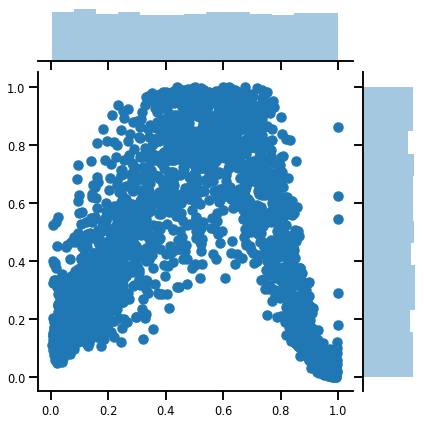

In [49]:
sns.jointplot(X_u[:, 0], X_u[:, 1])

#### Forward Transform

In [48]:
X_g = marginal_transform(X, forward_f, params)

chex.assert_equal_shape([X_g, X])

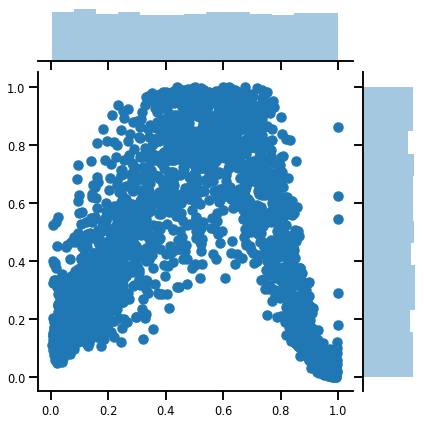

In [50]:
sns.jointplot(X_g[:, 0], X_g[:, 1])

#### Inverse Transformation

In [51]:
X_approx = marginal_transform(X_g, inverse_f, params)

chex.assert_equal_shape([X_approx, X])

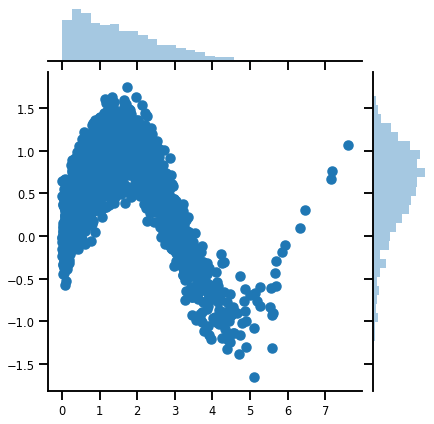

In [54]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])

## Marginal Gaussianization

In [69]:
from typing import Union, Callable
from rbig_jax.utils import get_domain_extension

import chex

@chex.dataclass
class UniGaussParams:
    support: chex.ArrayDevice
    quantiles: chex.ArrayDevice
    support_pdf: chex.ArrayDevice
    empirical_pdf: chex.ArrayDevice
        
        
def marginal_fit_transform(X, f: Callable):
    X, params = jax.vmap(f, out_axes=(0, 0))(X.T)
    return X.T, params

def marginal_transform(X, f: Callable, params):
    X = jax.vmap(f, in_axes=(0, 0), out_axes=1)(params, X.T)
    return X

def marginal_gaussianization(
    uni_uniformize: Callable,
    eps: float = 1e-5
):
    # unpack functions
    uni_init_f, uni_forward_f, uni_grad_f, uni_inverse_f = uni_uniformize
    
    # create marginal functions
    
    # TODO a bin initialization function
    def init_func(inputs):
        
        outputs, params = marginal_fit_transform(inputs, uni_init_f)
        
        outputs = np.clip(outputs, eps, 1 - eps)
        
        # forward transformation
        outputs = jax.scipy.stats.norm.ppf(outputs)
        
        return outputs, params
    
    def transform(params, inputs):
        
        inputs = marginal_transform(inputs, uni_forward_f, params)
        
        inputs = np.clip(inputs, eps, 1 - eps)

        return jax.scipy.stats.norm.ppf(inputs)

    def gradient_transform(params, inputs):
        
        # Log PDF of normalized data
        absdet = marginal_transform(inputs, uni_grad_f, params)
        
        logabsdet = np.log(absdet)
        
        # forward uniformization function        
        outputs = marginal_transform(inputs, uni_forward_f, params)
        
        # clip boundaries
        outputs = np.clip(outputs, eps, 1 - eps)
        
        # inverse cdf
        outputs = jax.scipy.stats.norm.ppf(outputs)
        
        # Log PDF for Gaussianized data
        logabsdet =  logabsdet - jax.scipy.stats.norm.logpdf(outputs)

        return outputs, logabsdet

    def inverse_transform(params, inputs):
        
        inputs = jax.scipy.stats.norm.cdf(inputs)
        
        outputs = marginal_transform(inputs, uni_inverse_f, params)
        
        
        return outputs
        
    
    return init_func, transform, gradient_transform, inverse_transform

In [70]:
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
uni_uniformize = univariate_histogram(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = marginal_gaussianization(uni_uniformize, eps)

### Fit Forward Transform

In [71]:
X_g, params = fit_transform_func(X)

<Figure size 432x288 with 0 Axes>

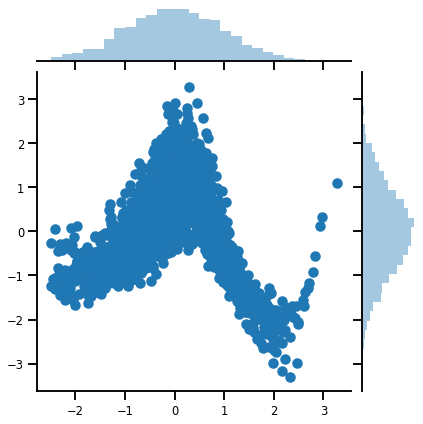

In [72]:
plt.figure()
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

#### Jitted

In [63]:
fit_transform_func_jitted = jax.jit(fit_transform_func)

In [64]:
_ = fit_transform_func_jitted(X) 
%timeit fit_transform_func(X.block_until_ready())
%timeit fit_transform_func_jitted(X.block_until_ready()) 

184 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
716 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Forward Transformation

In [73]:
X_g = forward_f(params, X)

<Figure size 432x288 with 0 Axes>

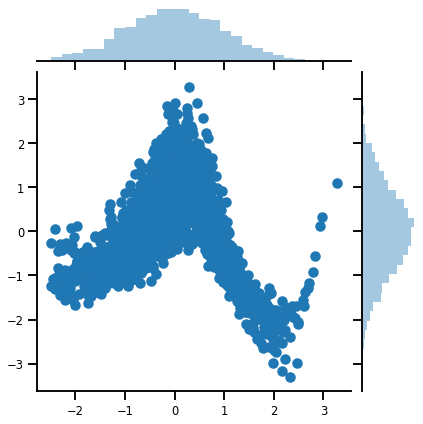

In [74]:
plt.figure()
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

### Inverse Transform

In [75]:
X_approx = inverse_f(params, X_g)

<Figure size 432x288 with 0 Axes>

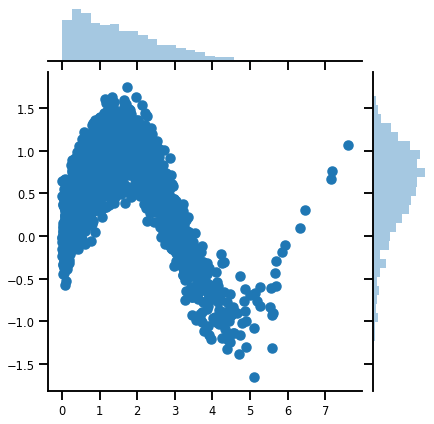

In [76]:
plt.figure()
sns.jointplot(X_approx[:, 0], X_approx[:, 1])
plt.show()

### Gradient Transform

In [77]:
X_g, X_ldj = grad_f(params, X)

<Figure size 432x288 with 0 Axes>

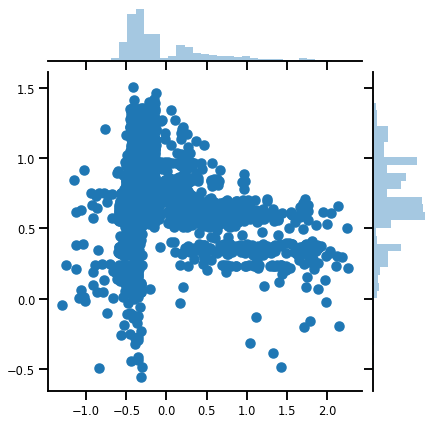

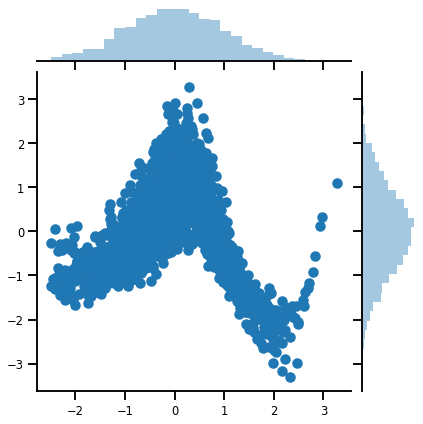

In [78]:
plt.figure()
sns.jointplot(X_ldj[:, 0], X_ldj[:, 1])
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()